# Generating Robot Names
## Using a RNN in Pytorch
In this notebook, we'll create a RNN language model that learns to generate new robot names from on existing robot names corpus from the past century - every robot name from movies, games and TV.

__Author__
Chris Kalle - R4 Robotics | r4robotics.com.au

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import unicodedata
import string
import random
import unidecode
import numpy as np
from tqdm import tqdm

#### Set up our datasource

In [2]:
## File path
file_name = "./data/robot-names.txt"

### Data exploration
Create a few helper functions to read the file as well as prepare it for ingestion into the network.

In [3]:
EOS = '\n'
all_characters = string.ascii_letters + " .,;'-0123456789" + EOS
n_letters = len(all_characters) # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_characters
    )

# Read a file and split into lines
def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Build the lines file
lines = open(file_name, encoding='utf-8').read().strip().split('\n')

file, file_len = read_file(file_name)
all_names = [unicodeToAscii(line) for line in lines]

n_names = len(all_names)

if n_names == 0:
    raise RuntimeError('Data not found.')

print('# names: {}, # chars: {}'.format(n_names, n_letters))
print("\n...")
for i in range(10):
    print("{}".format(all_names[np.random.randint(n_names)]))

# names: 702, # chars: 69

...
Evil Robot Axe Cop
Miss Impact
Alpha 7
Trurl
Robot Archie
X-bot
Marvin the Paranoid Android
Cubot
Zero one
Flying Termite


### Data processing
Let's implement some functions for aggegating and processing the data before assigning it to Tensor objects.

#### Random sampling
Here we implement random sampling for use in training.  Without random sampling, a powerful enough network is able to memorise the sequence of names and recursively output the given dataset.

In [4]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

#### Defining targets
Here we create a string to character tensor, up to the maximum length.

In [5]:
# String to tensor
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

#### Generating training batches
Next we create a minibatch based on a given chunk length.

In [6]:
# Make input, and target tensors from a random line
def random_training_set(chunk_len, batch_size):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    
    random.shuffle(all_names)
    dataset = '\n'.join(s for s in all_names)
    
    for bi in range(batch_size):
        start_index = random.randint(0, len(dataset) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        
        chunk = dataset[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    return inp, target

### Building the network

#### Creating the basic unit

In [7]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

#### Initialise the network

In [8]:
### Network Parameters ###
n_input_chars = n_letters
n_layers = 3
hidden_size = 128

In [9]:
decoder = CharRNN(
    n_input_chars,
    hidden_size,
    n_letters,
    n_layers=n_layers,
)

### Training the network

#### Define loss and training function

In [10]:
learning_rate = 0.0001

decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [11]:
#criterion = nn.NLLLoss()
### Training Parameters ###
print_every = 60
n_epochs = 2400
chunk_len = 250
batch_size = 32
cuda = False

save_filename = "Robomoniker-model-GRU.pt"

def train(inp, target):
    hidden = decoder.init_hidden(batch_size)
    
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[:,c], hidden)
        loss += criterion(output.view(batch_size, -1), target[:,c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

def save():
    torch.save(decoder, save_filename)
    print('Saved as %s' % save_filename)

#### Name generation function

In [12]:
import time
import math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

_Here a temperature parameter is used to control the randomness of the network_

In [13]:
max_length = 20

def generate(decoder, prime_str='A', max_names = 15, max_length = 100, temperature=0.8, cuda=False):
    hidden = decoder.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))

    if cuda:
        hidden = hidden.cuda()
        prime_input = prime_input.cuda()
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    names = []
    
    while len(names) < max_names:
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        top_i = max(0, min(top_i, len(all_characters)-1))

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char

        if (predicted_char == '\n' and len(predicted) > 0):
            names.append(predicted)
            predicted = ''
        
        inp = Variable(char_tensor(predicted_char).unsqueeze(0))
        if cuda:
            inp = inp.cuda()
    
    return ''.join(names)

### Training 

In [14]:
start = time.time()
all_losses = []
loss_avg = 0

try:
    if cuda:
        decoder.cuda()
    
    print("Training for %d epochs..." % n_epochs)
    for epoch in tqdm(range(1, n_epochs + 1)):
        loss = train(*random_training_set(chunk_len, batch_size))
        loss_avg += loss
        all_losses.append(loss)

        if epoch % print_every == 0:
            print('[%s (%d %d%%) loss = %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
            rand_char = random.choice(all_characters)
            print(generate(decoder, prime_str=rand_char, max_names=10, cuda=cuda), '\n')

    print("Saving...")
    save()

except KeyboardInterrupt:
    print("Saving before quit...")
    save()

Training for 2400 epochs...


  2%|█▉                                                                            | 59/2400 [01:45<1:04:48,  1.66s/it]

 46s (60 2%) loss = 3.6459]
xM44l5apKup
Q r
rtoEX
aaytsr;b
abtnot
Y
ou'

a
er
 



  5%|███▊                                                                         | 119/2400 [03:32<1:04:49,  1.70s/it]

 34s (120 5%) loss = 3.5522]
nGTRxd9eowuntlekrouyeHooMm rroobtyaeJdlnrrhaektnDDor noRreeeiNsrl
M
itaDpoTn
atara otrteJain
ohaHoonsbhBm

naAy
un siSe
ro
'O2Su
 



  7%|█████▋                                                                       | 179/2400 [05:21<1:03:22,  1.71s/it]

 23s (180 7%) loss = 3.4961]
bW0hz7rk
brbooaea
zTta0keoBt
i
noukoRl-tF- oWains
aDBobiptTveoiseotl
n 
Raoato0S
lSeneruno
no
 



 10%|███████▋                                                                     | 239/2400 [07:18<1:30:38,  2.52s/it]

 21s (240 10%) loss = 3.2304]
n.Fns
oimnhtM
RUtD
eCotai
ha
rRRea
aalEKegft
 yLu
iuhad
-en9
 



 12%|█████████▌                                                                   | 299/2400 [09:14<1:16:47,  2.19s/it]

 16s (300 12%) loss = 3.0276]
08L0r Let
Terya
Sbine
De 7atri
oTe
Nme-afien
Tuon
Rho
ea
KAuPgimDi
 



 15%|███████████▌                                                                 | 359/2400 [11:15<1:15:52,  2.23s/it]

 17s (360 15%) loss = 2.8916]
Ggkherree
Tlernr
Bhi Rbo
Ber
Coc
Zoid
AtNet
aEk Tusetorn
Ced Jaccit Hebor
Xhkie
 



 17%|█████████████▍                                                               | 419/2400 [13:18<1:11:13,  2.16s/it]

 20s (420 17%) loss = 2.7355]
W Dukant
Cob 51ot
Ysvat Kn0e Knn Non Ecinvhararyn
GRonob
Cadt Sarpos
Cinke
Ceaneno Voh
Robot
Mhav;o
ease
 



 20%|███████████████▎                                                             | 479/2400 [15:25<1:06:54,  2.09s/it]

 28s (480 20%) loss = 2.6684]
Pc40j
Dliilv Sapin Rosdei
Dorne Te 3-7
A7goruthrric
Taana urapro 20N
Deed Ganlot
Ler
Va
Slanacs ManlI
Oan
 



 22%|█████████████████▎                                                           | 539/2400 [17:27<1:02:32,  2.02s/it]

 29s (540 22%) loss = 2.5680]
lqemir Geran Robot
Saca AllzrBerd
Jo Robot
Drin
Zor
SIFlpa
bacthe
Robobot
Cherceat
Tanomotbot
 



 25%|███████████████████▏                                                         | 599/2400 [19:24<1:03:32,  2.12s/it]

 25s (600 25%) loss = 2.5031]
6;5 KKi
Siclk
P
Karakararas
Droton
Tobot
Teralon
Sprast Robot
C-LFot
Araceunt
 



 27%|█████████████████████▏                                                       | 659/2400 [21:45<1:10:33,  2.43s/it]

 47s (660 27%) loss = 2.4283]
x,010
Gorbot
Meratiar
Teaghroco
D-A90
Thi
6s
Robot
Coves
Penes Selmter
 



 30%|███████████████████████▋                                                       | 719/2400 [23:48<57:32,  2.05s/it]

 51s (720 30%) loss = 2.3518]
9h
Shurgor
Ted Endate Berd
Daraser Robot Robot
Branlie
Sezae
Ginticocbot
Colde
Ro.
Triciy Bot
 



 32%|█████████████████████████▋                                                     | 779/2400 [25:47<50:28,  1.87s/it]

 49s (780 32%) loss = 2.2835]
,cEf
Serngerd
Acse Dengerros
Raglack
Mace
Androzer
Endar Robor
IHBacD
Tunuto
llan
 



 35%|███████████████████████████▌                                                   | 839/2400 [27:42<51:11,  1.97s/it]

 44s (840 35%) loss = 2.2137]
in0
Zicfot
Covanaharke
Tid Robot
Fertroy
Mundest lund
Jani Zare 3000
Guhearasion
Robot
Foidko
 



 37%|█████████████████████████████▌                                                 | 899/2400 [29:39<48:36,  1.94s/it]

 43s (900 37%) loss = 2.1740]
stanrian
Trous
Jick .obot
Musk
Malpara
Cyligod
The Kadath Guilter
Wanonal Robot
Nac Serna
Comber ton
 



 40%|███████████████████████████████▌                                               | 959/2400 [31:44<50:43,  2.11s/it]

 46s (960 40%) loss = 2.0992]
shid Sersher Cur Nar Flidz Motter 4
Denmhar
CARR Kazaranona
Ringer
Malt Seslorl
Volimar Imam Ro-Luv
Cing 3000
Drisk
Robot Dral
Robot
 



 42%|█████████████████████████████████                                             | 1019/2400 [33:37<38:52,  1.69s/it]

 38s (1020 42%) loss = 2.0433]
Enachantrer
Mecter Ephiee
Ally Robot Marla
Assillt
DrO9
Chulto tis
Emuca tor Zero
Cony Rodeco
Parabot Robot
uomon
 



 45%|███████████████████████████████████                                           | 1079/2400 [35:42<39:50,  1.81s/it]

 43s (1080 45%) loss = 2.0065]
clata Joan
Guukent
Malinectrobot
Frobot
Borbo
The Prois
Dran
Minn Espha Roboid
Batro
Puliscinge Ictor
 



 47%|█████████████████████████████████████                                         | 1139/2400 [37:42<40:23,  1.92s/it]

 45s (1140 47%) loss = 1.9166]
mass
The Robot Thean
Joem The Broin
Sergeant
Robot Elpy Alder Lan
Ezecrob Aldus
Torl
Promian
Tork
102
 



 50%|██████████████████████████████████████▉                                       | 1199/2400 [39:41<40:01,  2.00s/it]

 44s (1200 50%) loss = 1.8598]
ntron
HARY
Ivic
Malner Edelil
Comodobot
Comber Mang
Lendy And
The Lan
Marpy Man Metace
Nix U'
 



 52%|████████████████████████████████████████▉                                     | 1259/2400 [41:46<44:04,  2.32s/it]

 48s (1260 52%) loss = 1.8177]
G
Raptear
Sallingein Zerot
Spim
Robord
Chice
Mict 5
Tinator
Mara
Geda
 



 55%|██████████████████████████████████████████▊                                   | 1319/2400 [43:44<38:42,  2.15s/it]

 46s (1320 55%) loss = 1.7601]
yridon Man
Nozbot
Schto 1M
Drbot
Buster
Dr. Evakattro
Dahck Etharal Emilaton
Inks Rober
Olimicon
Roboto
 



 57%|████████████████████████████████████████████▊                                 | 1379/2400 [45:46<29:44,  1.75s/it]

 48s (1380 57%) loss = 1.7115]
etron
Spectroson
Alphes
Spaper Robot
Chile
Taclurs
ST1000
Robot Srinbot
Gurtlic
Robot HMOR-8
 



 60%|██████████████████████████████████████████████▊                               | 1439/2400 [47:46<36:31,  2.28s/it]

 48s (1440 60%) loss = 1.6795]
HJCNo
Kahatlincloid the Robot
Winky Robot
Cochnt Man
IV Ter Shean
Lindroid
Cuse
Chiig
Kotone 1
Barsemica
 



 62%|████████████████████████████████████████████████▋                             | 1499/2400 [49:45<41:33,  2.77s/it]

 48s (1500 62%) loss = 1.6550]
H9-817
Tilly
Jeant
Mave Mochren
Roboy Ger
Serfous Promic
Wustor A0Na
Spreslot
Nh-27
Busy
 



 65%|██████████████████████████████████████████████████▋                           | 1559/2400 [51:48<26:02,  1.86s/it]

 50s (1560 65%) loss = 1.5917]
6
T-3
Rectoro
Stellebot
Mega
Stalles 2
Brandes
Wearmesd the Labot
Pik
Geattron
 



 67%|████████████████████████████████████████████████████▌                         | 1619/2400 [53:50<28:45,  2.21s/it]

 52s (1620 67%) loss = 1.5912]
J5
Noman
Danace Lon
Jack Zane Iron
Mr Robot
Hema
Taun of Tetlort 8
Sher Mander
Dakanl Pore Robot
Ro-9
 



 70%|██████████████████████████████████████████████████████▌                       | 1679/2400 [55:52<20:43,  1.73s/it]

 55s (1680 70%) loss = 1.4913]
ler Hammes
Comber Robot
Naxon
HAL-9000
Gallex Man
Sccleeter
Daven
Tesam
Renderal
Cybot
 



 72%|████████████████████████████████████████████████████████▌                     | 1739/2400 [57:49<18:53,  1.72s/it]

 53s (1740 72%) loss = 1.5025]
lyn All Crill Creadian
Battle Cos
Cyanous 7-00
Grachunder
The Daveger
Malton
Dallinal Apia
Chip
Zerohd
Azakinan
 



 75%|██████████████████████████████████████████████████████████▍                   | 1799/2400 [59:58<31:18,  3.13s/it]

 0s (1800 75%) loss = 1.4229]
gr Man
Devadructy
Bral Man
Teney
Olimnip Sergin
Marget
Adam
Clicker
Sectonetron
Sectomora 900
 



 77%|██████████████████████████████████████████████████████████▊                 | 1859/2400 [1:01:55<16:00,  1.77s/it]

 57s (1860 77%) loss = 1.3736]
mudt Clorche
Zero
Ixot
Orcho
Cony Winen
Janes
MALk
Cyanuro
Terminator
Dr. Poper
 



 80%|████████████████████████████████████████████████████████████▊               | 1919/2400 [1:03:55<14:19,  1.79s/it]

 56s (1920 80%) loss = 1.3689]
L
Karus Six
Deitur Trune Quee
Beatron
C5 3000
Nart
Astra
To-bot
Voltrie
Intureno
 



 82%|██████████████████████████████████████████████████████████████▋             | 1979/2400 [1:06:01<15:03,  2.15s/it]

 3s (1980 82%) loss = 1.3052]
gr
Specter
Chice
SURON
K1-R
Junnem Sermant
Valeed
Dallic Sinop
Link
The Oreato
 



 85%|████████████████████████████████████████████████████████████████▌           | 2039/2400 [1:08:00<10:32,  1.75s/it]

 2s (2040 85%) loss = 1.3002]
HwIDk
Stella Todrace
Orsion
Bester
Android 6
Combot
Madaybot
Trize
Shoobord
BriZame
 



 87%|██████████████████████████████████████████████████████████████████▍         | 2099/2400 [1:10:08<10:26,  2.08s/it]

 10s (2100 87%) loss = 1.2629]
;
Pinsmoud
Cledbot
Elektrobot
Robo-Lame
Murg
Tilly
Co-4o
Iras
Gindertrecto
 



 90%|████████████████████████████████████████████████████████████████████▎       | 2159/2400 [1:12:04<07:00,  1.74s/it]

 7s (2160 90%) loss = 1.2171]
Wyfter the Havunk
Dalave Sergeant Braebot
Tonto
Go-bot
Froch-B
Golitmura
Maranoid 2000
Mark Qoo
MMO
Machine Gort
 



 92%|██████████████████████████████████████████████████████████████████████▎     | 2219/2400 [1:14:03<05:30,  1.83s/it]

 5s (2220 92%) loss = 1.1908]
chrbot
Corty 500
Med-Za
Mama Wating
Robo-Lawyer
Octango-8
XBus
Robot Bos
Tisl
Robot Thanama of the Bolbot
 



 95%|████████████████████████████████████████████████████████████████████████▏   | 2279/2400 [1:16:12<04:36,  2.28s/it]

 14s (2280 95%) loss = 1.1746]
23 Robot
Krus
T-1000
Androtars
Tor
Golick
T-9
Jacks
Marhic
Borc
 



 97%|██████████████████████████████████████████████████████████████████████████  | 2339/2400 [1:18:11<02:19,  2.29s/it]

 12s (2340 97%) loss = 1.1315]
ight Mand
Blitk
Young Irox
Spute
Lothar
Jinns
Spot
Cindersibot
SAR-N9
Scrubot
 



100%|███████████████████████████████████████████████████████████████████████████▉| 2399/2400 [1:20:21<00:02,  2.56s/it]

 23s (2400 100%) loss = 1.1256]
Qjoot
Dunss
Marvin tega
Space 45
Robo-Taxro
Drone
Alpha Indectro Apha Bowbot
PDoG3
Spadeet
Number Tank
 



100%|████████████████████████████████████████████████████████████████████████████| 2400/2400 [1:20:23<00:00,  2.39s/it]


Saving...


C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CharRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saved as Robomoniker-model-GRU.pt


#### Training loss history

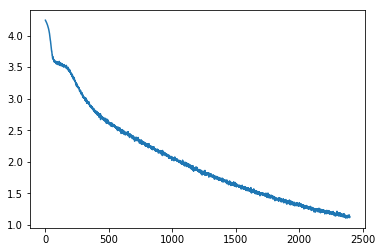

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [16]:
save()

C:\Users\palladium\AppData\Local\Continuum\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type CharRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Saved as Robomoniker-model-GRU.pt


### Let's robot!

In [17]:
decoder = torch.load(save_filename)
primer = string.ascii_letters[np.random.randint(low=26, high=52)]
print(generate(decoder, prime_str=primer, max_names = 20))

T
Number Six
Cutie
Irtac
Davica
Biobot
She-x
The Dagarmiito
Norby
Satanputa
Tanaan
Tom Clinker
Dagsssvent
Johnny Kachning
Medabot
Robot Thincy
Jacks
Metla Man
Medbot
Young Tama

